# Image Captioning with Attention

Using an attention based Inception V3 model to caption the MS-COCO Dataset


In [2]:
#Import Dependencies

import tensorflow as tf

# Plots of attention 
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json

#finding Pathnames
from glob import glob

from PIL import Image

#pickle helps (de)serialise python objects
import pickle

## Download MS-COCO Dataset

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

252878848/252872794 [==============================] - 8s 0us/step


In [4]:
# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 371s 0us/step


## Prepare Dataset

In [5]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image names and set random seed
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [6]:
# OPTIONAL: Select the first 30000 captions from the shuffled set
# more training examples increases time but gives better accuracy 
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [7]:
print('Number of training caption examples: ', len(train_captions))
print('Total captions: ', len(all_captions)) 

Number of training caption examples:  30000
Total captions:  414113


## Preprocess the images using InceptionV3

InceptionV3's expected format:

*   Image size 299 x 299 px : Resize image
*   Pixel range -1 to 1 : use the preprocess_input method to normalise



In [8]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.resize(img, (299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

## Initialise InceptionV3 and load pretrained Imagenet weights

Creating a tf.keras model where output layer is last convolutional layer of the InceptionV3 architecture, shape (8x8x2048). This layer is used for attention



Do not perform this initialisation during training, it could become a bottleneck

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top = False, weights ='imagenet')

new_input = image_model.input

hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 3s 0us/step


## Cache extracted features

Cache on disk. RAM would be faster but would require 8x8x2048 floats per image so nah

In [10]:
#Adding a progress bar to make life easy

!pip install -q tqdm

from tqdm import tqdm

In [11]:
#get sorted unique names
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
#AUTOTUNE automatically tunes performance knobs
image_dataset = image_dataset.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(16)

#if not using the progress bar, simply use for img, path in image_dataset
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf,p in zip(batch_features, path):
    path_of_feature = p.numpy().decode('utf-8')
    np.save(path_of_feature, bf.numpy())

100%|██████████| 1622/1622 [05:33<00:00,  4.86it/s]


## Preprocess Text

Preprocessing includes:


1.   Tokenising
2.   Limit vocab size to 5,00 words, other words replaced with 'UNK'
3.   Word-to-index and Index-to-word mappings
4.   Pad all sequences to be the same length (as longest sentence)



In [12]:
#Finding max length of caption

def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [13]:
#Choose top 5000 words from vocabulary

top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                   oov_token = '<unk>',
                                                   filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
#Create tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

#Pad to maxlength of captions (pad_sequences calculated automatically), apply padding at the end
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding ='post')

#calculate max length, USED TO STORE THE ATTENTION WEIGHTS
max_length = calc_max_length(train_seqs)

## Split Training and Testing Data

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
#Training and validation using 80-20 split

img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size = 0.2, random_state =0)

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Creating Training Dataset

In [20]:
#Parameters

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048), represented by the two variables
features_shape = 2048
attention_features_shape = 64



In [21]:
#load files

def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# map loads the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Building the Model

This model is based on the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) model using [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf)

In [33]:
class BahdanauAttention(tf.keras.Model):
  #extract features from the lower convolutional layer of InceptionV3 (shape (8,8,2048)
  #Squash to shape (64,2048)
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [34]:
class CNN_Encoder(tf.keras.Model):
  #Features have been extracted and dumped using features
  #Here features are passed through the CNN encoder, which is one fully connected layer
   
  def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        #shape after fc == (batch_size, 64, embedding_dim)"
        self.fc = tf.keras.layers.Dense(embedding_dim)

  def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [35]:
class RNN_Decoder(tf.keras.Model):
  #RNN attends over image to predict next word
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    #define attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    #x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [36]:
#initialise encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [37]:
#using Adam optimizer
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoint

In [38]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training


1.   Extract features from .npy files and pass to encoder
2.   Encoder output, hidden state (initialuzed to 0), decoder input (start token) passed to decoder, which returns predictions and decoder hidden state
3. Decoder hidden state passed back to model; predictions used to calculate loss
4. Use Teacher forcing (Target word passed as next input to decoder) 
5. Calculate graduents, backprop and optimize



In [39]:
# adding this in a separate cell because if training cell is run many times, the loss_plot array will be reset
loss_plot = []

In [40]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [41]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0347
Epoch 1 Batch 100 Loss 1.1169
Epoch 1 Batch 200 Loss 1.0226
Epoch 1 Batch 300 Loss 0.9188
Epoch 1 Loss 1.035350
Time taken for 1 epoch 384.2486400604248 sec

Epoch 2 Batch 0 Loss 0.8182
Epoch 2 Batch 100 Loss 0.7905
Epoch 2 Batch 200 Loss 0.8029
Epoch 2 Batch 300 Loss 0.7522
Epoch 2 Loss 0.788569
Time taken for 1 epoch 364.54731845855713 sec

Epoch 3 Batch 0 Loss 0.7561
Epoch 3 Batch 100 Loss 0.7305
Epoch 3 Batch 200 Loss 0.7022
Epoch 3 Batch 300 Loss 0.6717
Epoch 3 Loss 0.718650
Time taken for 1 epoch 361.46533823013306 sec

Epoch 4 Batch 0 Loss 0.6805
Epoch 4 Batch 100 Loss 0.7129
Epoch 4 Batch 200 Loss 0.6944
Epoch 4 Batch 300 Loss 0.6713
Epoch 4 Loss 0.674382
Time taken for 1 epoch 361.1406579017639 sec

Epoch 5 Batch 0 Loss 0.6861
Epoch 5 Batch 100 Loss 0.6625
Epoch 5 Batch 200 Loss 0.6056
Epoch 5 Batch 300 Loss 0.6180
Epoch 5 Loss 0.638783
Time taken for 1 epoch 360.81355905532837 sec

Epoch 6 Batch 0 Loss 0.5877
Epoch 6 Batch 100 Loss 0.5940
Epoch 6 B

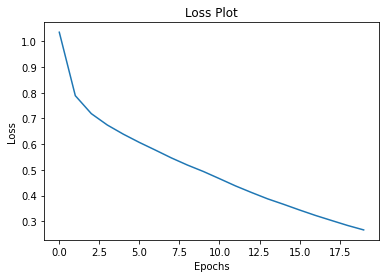

In [42]:
#plotting loss
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Captioning

 No teacher forcing is used. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
 Prediction stops when end token is predicted.

In [44]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
          #if model predicts the end token return
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [45]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> there is a man and a woman sitting on two couches <end>
Prediction Caption: the sun with a sheet <unk> in the room <end>


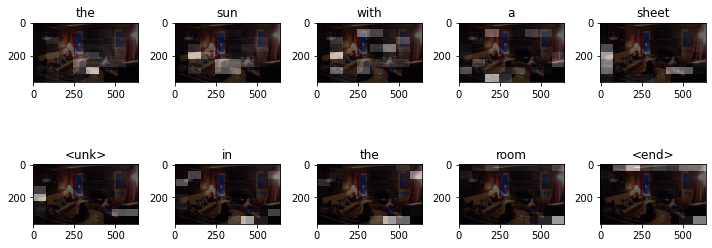

In [46]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
